# 퇴근시간 버스승차인원 예측경진대회

## 0. Info
* Type: Regression
* URL: https://dacon.io/competitions/official/229255/leaderboard/?tab=submit
* Reference
    * https://www.kaggle.com/xkagjaeo05/t-bus-passenger-prediction

## 1. Setting

In [ ]:
import os
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

from lightgbm import LGBMRegressor

In [ ]:
SEED = 1993
BASE_DIR = '/content/drive/Shareddrives/Yoon/Project/Doing/Data Science Competition/Dacon/Bus Passenger Prediction'

## 2. Data

In [ ]:
def categorize(train_data, test_data, column, to_categorical=True):
    encoder = LabelEncoder()
    encoder.fit(train_data[column].append(test_data[column]))
    train_data[column] = encoder.transform(train_data[column])
    test_data[column] = encoder.transform(test_data[column])

    if to_categorical:
        train_data[column] = pd.Categorical(train_data[column])
        test_data[column] = pd.Categorical(test_data[column])

### General

In [ ]:
data_path = os.path.join(BASE_DIR, 'data.zip')
!unzip "{data_path}" -d 'data'

Archive:  /content/drive/Shareddrives/Yoon/Project/Doing/Data Science Competition/Dacon/Bus Passenger Prediction/data.zip
  inflating: data/행정_법정동 중심좌표.xlsx  
  inflating: data/test.csv           
  inflating: data/train.csv          
  inflating: data/submission_sample.csv  
  inflating: data/bus_bts.csv        


In [ ]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
bus_data = pd.read_csv('data/bus_bts.csv')

In [ ]:
display(train_data.head())
display(test_data.head())

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
0,415423,2019-10-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,415424,2019-10-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0
2,415425,2019-10-01,4270000,시외,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,415426,2019-10-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
4,415427,2019-10-01,4270000,시내,1636,롯데호텔,33.24872,126.41032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
print(f"train data size: {train_data.shape}")
print(f"test  data size: {test_data.shape}")

train data size: (415423, 21)
test  data size: (228170, 20)


In [ ]:
print('train data null values')
display(train_data.isnull().sum())

print('=' * 50)

print('test data null values')
display(test_data.isnull().sum())

train data null values


id               0
date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
18~20_ride       0
dtype: int64

test data null values


id               0
date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
dtype: int64

In [ ]:
train_data.columns.difference(test_data.columns)

Index(['18~20_ride'], dtype='object')

In [ ]:
print('train data id')
display(train_data['id'].agg(['min', 'max']))

print('=' * 50)

print('test data id')
display(test_data['id'].agg(['min', 'max']))

train data id


min         0
max    415422
Name: id, dtype: int64

test data id


min    415423
max    643592
Name: id, dtype: int64

### Date

In [ ]:
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

In [ ]:
print('train data date')
display(train_data['date'].agg(['min', 'max']))

print('=' * 50)

print('test data date')
display(test_data['date'].agg(['min', 'max']))

train data date


min   2019-09-01
max   2019-09-30
Name: date, dtype: datetime64[ns]

test data date


min   2019-10-01
max   2019-10-16
Name: date, dtype: datetime64[ns]

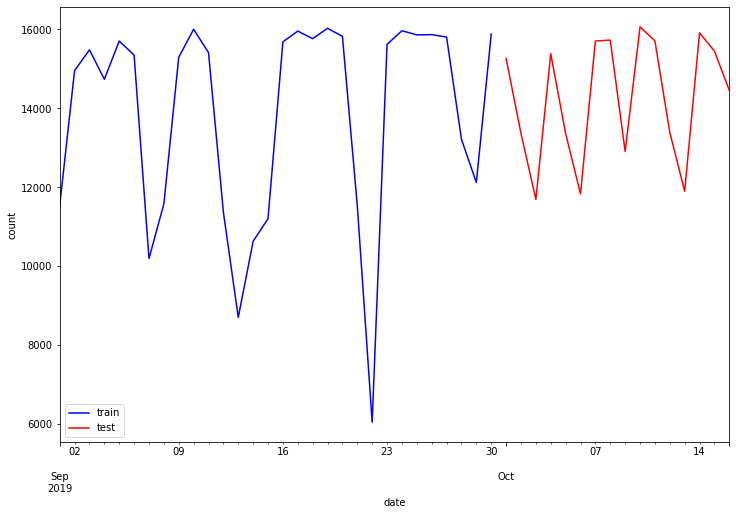

In [ ]:
plt.figure(figsize=(12, 8))
train_data['date'].value_counts().sort_index().plot(color='b', label='train')
test_data['date'].value_counts().sort_index().plot(color='r', label='test')
plt.legend()
plt.xlabel('date')
plt.ylabel('count')
plt.show()

In [ ]:
train_data['weekday'] = train_data['date'].dt.weekday
test_data['weekday'] = test_data['date'].dt.weekday

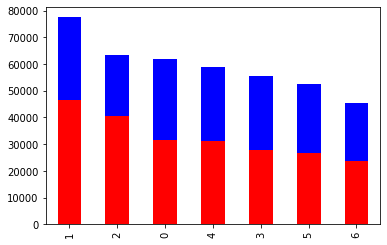

In [ ]:
train_data['weekday'].value_counts().plot(kind='bar', color='b')
test_data['weekday'].value_counts().plot(kind='bar', color='r')
plt.show()

### Bus route id

In [ ]:
train_route_id = set(train_data['bus_route_id'])
test_route_id = set(test_data['bus_route_id'])

In [ ]:
print(f'# of unique route of train data: {len(train_route_id)}')
print(f'# of unique route of test  data: {len(test_route_id)}')
print(f'# of unique route of both  data: {len(train_route_id.intersection(test_route_id))}')
print(f'# of unique route of train data not in test data: {len(train_route_id.difference(test_route_id))}')
print(f'# of unique route of test data not in train data: {len(test_route_id.difference(train_route_id))}')

# of unique route of train data: 613
# of unique route of test  data: 601
# of unique route of both  data: 583
# of unique route of train data not in test data: 30
# of unique route of test data not in train data: 18


In [ ]:
only_test_route_id = test_route_id.difference(train_route_id)
test_data.loc[test_data['bus_route_id'].isin(only_test_route_id)]

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
510,415933,2019-10-01,21510000,시내,2746,서귀포등기소,33.25314,126.56015,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
511,415934,2019-10-01,21510000,시내,6115100,서귀포시외버스터미널,33.24873,126.50799,0.0,11.0,2.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0
11209,426632,2019-10-01,29850000,시내,2,오광로입구,33.49527,126.45618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
11210,426633,2019-10-01,29850000,시내,4,이호2동,33.49488,126.46137,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11211,426634,2019-10-01,29850000,시내,26,하귀초등학교,33.48017,126.40212,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228157,643580,2019-10-16,32790000,시내,1705,서귀포우체국서귀포시청제2청사,33.25507,126.51007,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
228158,643581,2019-10-16,32790000,시내,2970,제주시외버스터미널(종점),33.49993,126.51414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0
228159,643582,2019-10-16,32790000,시내,3062,서귀포시외버스터미널(가상정류소),33.24985,126.50723,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
228160,643583,2019-10-16,32790000,시내,3072,회수마을회관,33.26323,126.44466,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
categorize(train_data, test_data, 'bus_route_id', to_categorical=True)
train_data.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday
0,0,2019-09-01,0,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1,1,2019-09-01,0,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6
2,2,2019-09-01,0,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6
3,3,2019-09-01,0,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,6
4,4,2019-09-01,0,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6


### In out

In [ ]:
train_data['in_out'].unique()

array(['시외', '시내'], dtype=object)

In [ ]:
categorize(train_data, test_data, 'in_out', to_categorical=True)
train_data.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday
0,0,2019-09-01,0,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1,1,2019-09-01,0,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6
2,2,2019-09-01,0,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6
3,3,2019-09-01,0,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,6
4,4,2019-09-01,0,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6


### Station code

In [ ]:
categorize(train_data, test_data, 'station_code', to_categorical=True)
train_data.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday
0,0,2019-09-01,0,1,322,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
1,1,2019-09-01,0,1,335,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,6
2,2,2019-09-01,0,1,408,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6
3,3,2019-09-01,0,0,1448,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,6
4,4,2019-09-01,0,0,1510,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6


### Target

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


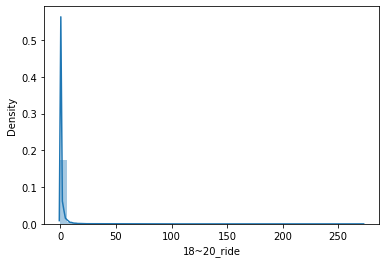

In [ ]:
sns.distplot(train_data['18~20_ride'])
plt.show()

In [ ]:
train_data.loc[train_data['18~20_ride'] == 0]

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,5,2019-09-01,4270000,시내,1648,예래입구,33.25862,126.40442,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7,7,2019-09-01,4270000,시외,1666,창천리,33.26598,126.37082,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,9,2019-09-01,4270000,시내,2008,서귀포항,33.23977,126.56450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,415418,2019-09-30,32820000,시내,1129,한림환승정류장(한림리),33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415419,415419,2019-09-30,32820000,시내,1564,제주시외버스터미널,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415420,415420,2019-09-30,32820000,시내,2322,해병부대,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
415421,415421,2019-09-30,32820000,시내,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. Model

In [ ]:
features = ['bus_route_id', 'in_out', 'station_code', '6~7_ride', '7~8_ride', '8~9_ride',
            '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
            '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 'weekday']
target = '18~20_ride'

In [ ]:
X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]

In [ ]:
n_splits= 5
NUM_BOOST_ROUND = 100000
lgbm_param = {'objective':'rmse',
              'boosting_type': 'gbdt',
              'random_state':1993,
              'learning_rate':0.1,
              'subsample':0.7,
              'tree_learner': 'serial',
              'colsample_bytree':0.78,
              'subsample_freq': 1,
              'reg_lambda':7,
              'reg_alpha': 5,
              'num_leaves': 96,
              'seed' : SEED
            }

In [ ]:
kfold = KFold(5, random_state=SEED, shuffle=True)
lgbm_oof_train = np.zeros((train_data.shape[0]))

In [ ]:
for idx, (train_idx, val_idx) in tqdm(enumerate(kfold.split(X_train, y_train))):
    _X_train, _y_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
    _X_val, _y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]

    model = LGBMRegressor(**lgbm_param)
    model.fit(_X_train, _y_train)
    _pred = model.predict(_X_val)
    lgbm_oof_train[val_idx] = _pred

In [ ]:
val_score = np.mean(np.sqrt((np.square(y_train - lgbm_oof_train))))
print(f'RMSE: {val_score:.3f}')

RMSE: 0.847


## 4. Submission

In [ ]:
submission = pd.read_csv('data/submission_sample.csv')
submission.head()

,id,18~20_ride
0,415423,0
1,415424,0
2,415425,0
3,415426,0
4,415427,0


In [ ]:
pred = model.predict(X_test)
submission['18~20_ride'] = pred

In [ ]:
submission.to_csv('submission.csv', index=False)